Decision Tree Classifier.
All the algorithm -ID3, C4.5 and CART are implemented here

In [ ]:
import numpy as np
import pandas as pd
from graphviz import Digraph

In [ ]:
class DecisionTreeClassifier:
  

  ## Constructor for the Decision Tree Classifier Class
  def __init__(self,algorithm):
    self.__node_list={}
    self.__value= None
    self.__column = None
    self.__algorithm_dic={"CART":self.__CART,"ID3":self.__ID3,"C4.5":self.__C45}
    
    if algorithm not in ["CART","ID3","C4.5"]:
      raise Exception("Invalid value of 'algorithm'. Possible Value: 'CART', 'ID3', 'C4.5'")
    else:
      self.__algorithm = algorithm

  ### Some Helper Function
  ##Entropy Function

  def __calEntropy(self,X,Y=None):
    X_unique,X_counts = np.unique(X,return_counts=True)

    if Y is None:
      res = X_counts/np.sum(X_counts)
      res = res*np.log2(res)
      return -np.sum(res)
    if Y is not None:
      res=0
      for i,j in zip(X_unique,X_counts):
        Y_unique,Y_counts = np.unique(Y[X==i],return_counts=True)
        Y_counts = Y_counts/np.sum(Y_counts)
        Y_counts = Y_counts*np.log2(Y_counts)
        Y_counts = -np.sum(Y_counts)
        res = res + (j/np.sum(X_counts))*Y_counts
      return res

  ## Function for calculating Gain
  def __calGain(self,column):
    E_s = self.__calEntropy(X=self.y)
    res = self.__calEntropy(self.X_train[:,column],self.y)
    res = E_s-res
    return res

  ## Function for calculating Gini
  def __calGini(self,column):
    res = 0
    a,b=np.unique(self.X_train[:,column],return_counts=True)
    for i,j in zip(a,b):
      Y_unique,counts = np.unique(self.y[self.X_train[:,column]==i],return_counts=True)
      counts = counts/np.sum(counts)
      counts = counts*counts
      counts = 1 - counts.sum()
      res = res + (j/self.X_train.size)*counts
    return res

  ### ID3 algorithm
  def __ID3(self):
    gains=np.array([])
    for i in range(self.X_train[0].size):
      gain = self.__calGain(i)
      gains = np.append(gains,[gain],axis=0)
    print(gains)
    print("-----------------------")
    return np.argmax(gains)
  
  ### C4.5 algorithm
  def __C45(self):
    gains = np.array([])
    for i in range(self.X_train[0].size):
      gain = self.__calGain(i)
      gains = np.append(gains,[gain],axis=0)

    #print(gains)
    split_infos = np.array([])
    for i in range(self.X_train[0].size):
      split_info = self.__calEntropy(X=self.X_train[:,i])
      split_infos= np.append(split_infos,[split_info],axis=0)
    #print(split_infos)
    gain_ratio = gains/split_infos
    return np.argmax(gain_ratio)
  
  ### CART algorithm
  def __CART(self):
    ginis=np.array([])
    for i in range(self.X_train[0].size):
      gini = self.__calGini(i)
      ginis = np.append(ginis,[gini],axis=0)
    #print(ginis)
    return np.argmin(ginis)

  ### Build method is used here with fit method to build the entire decision tree
  def __build(self,X_train,y):
    self.X_train=X_train
    self.y=y
    if X_train.size == 0:
      return
    elif X_train[0].size == 1:
      most_frequent_value,counts = np.unique(y,return_counts=True)
      most_frequent_value = most_frequent_value[counts==counts.max()]
      self.__value=most_frequent_value[0]
      self.__column=0
    elif np.unique(y).size == 1:
      self.__value = y[0]
    else:
      self.__column = self.__algorithm_dic[self.__algorithm]()
      for i in np.unique(X_train[:,self.__column],axis=0):
        self.__node_list[i]=DecisionTreeClassifier(self.__algorithm)
        X_pass_data = X_train[X_train[:,self.__column]==i]
        X_pass_data = np.delete(X_pass_data,self.__column,axis=1)
        y_pass_data = y[X_train[:,self.__column]==i]
        self.__node_list[i].__build(X_pass_data,y_pass_data)
        #print(self.__column)
    del self.X_train
    del self.y



  ### Method for training the classifier
  def fit(self,X,y):
    if type(X) != np.ndarray:
      raise Exception("The X variable should be a numpy 2 dimensional array")
    if type(y) != np.ndarray:
      raise Exception("The y variable should be a numpy array")
    if X.ndim != 2:
      raise Exception("The numpy array should be 2 dimensional")
    self.__build(X,y)
    print("Model Training is done")

  ### Method for predicting the output
  def __pred(self,x):
    if self.__value is None and self.__column is None:
      raise Exception("You have to first train the model")
    
    if type(x) is not np.ndarray:
      raise Exception("Input Invalid. Input must be numpy 2 dimensional array")

    if self.__value is not None:
      return self.__value
    if self.__column is None:
      return

    return self.__node_list[x[0,self.__column]].__pred(np.delete(x,self.__column,axis=1))
  
  def predict(self,x):
    if self.__value is None and self.__column is None:
      raise Exception("You have to train the model first")
    
    if type(x) is not np.ndarray:
      raise Exception("Input Invalid. Input must be numpy 2 dimensional array")
    result = []

    for i in x:
      result.append(self.__pred(np.reshape(i,(1,-1))))
    return result
  
  ### Method for visualizing the decision tree
  def __helpvis(self,graph,num,prev_num=None,edgeName=None,labels=None):
    if self.__value is None and self.__column is None:
      return (graph,num)
    
    if self.__value != None:
      graph.node(str(num),label=str(self.__value),shape="rect",color="green")
      if prev_num is not None:
        graph.edge(str(prev_num),str(num),label=edgeName)
      return (graph,num+1)
    
    if labels is not None:
      lb = labels[self.__column]
    else:
      lb = str(num)
    graph.node(str(num),label=lb)

    if prev_num is not None:
      graph.edge(str(prev_num),str(num),label=edgeName)

    p_num=num
    num=num+1
    for i,j in self.__node_list.items():
      if labels is not None:
        temp_labels = np.delete(labels,self.__column)
      else:
        temp_labels=None
      graph,num=j.__helpvis(graph,num,p_num,edgeName=str(i),labels=temp_labels)
    return (graph,num+1)
  
  def visualize(self,labels=None):
    if self.__value is None and self.__column is None:
      raise Exception("You have to train the model first")
    graph = Digraph()
    graph= self.__helpvis(graph=graph,num=0,labels=labels)[0]
    return graph

In [ ]:
model = DecisionTreeClassifier("CART")
#model.fit(np.array([[0,0],[0,1],[1,0],[1,1]]),np.array([0,0,0,1]))
X_train = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
y = np.array([1,1,0,0,1,1,1,1])
model.fit(X_train,y)
model.predict(np.array([[1,1,0]]))

Model Training is done


[1]

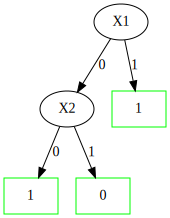

In [ ]:
model.visualize(labels=["X1","X2","X3"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
X = pd.read_csv("/content/drive/MyDrive/sample/PlayTennis_Train.csv")
y = X.iloc[:,-1].to_numpy(dtype=str)
X = X.iloc[:,0:4]
columns = X.columns.to_numpy(dtype=str)
X = X.to_numpy(dtype=str)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = DecisionTreeClassifier("C4.5")
model.fit(X,y)
model.visualize(columns)
model.predict(X)

Model Training is done


['No',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'No',
 'Yes',
 'No',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'Yes',
 'No']

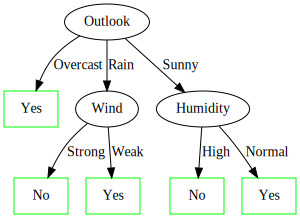

In [ ]:
model.visualize(columns)

In [ ]:
data = np.array([[1,2,3],[4,5,6]])

[1 2 3 4 5 6]
